In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import sys
sys.path.append('..')

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
!ls ../_data/*.csv

../_data/sample_submission.csv	../_data/test.csv  ../_data/train.csv


In [4]:
train = pd.read_csv('../_data/train.csv', low_memory=False)
# test = pd.read_csv('../_data/test.csv', low_memory=False)

In [5]:
train.shape, test.shape

((260753, 299), (173836, 298))

In [6]:
train.apply(lambda x: sum(x.isnull()), axis=0)

QuoteNumber                  0
Original_Quote_Date          0
QuoteConversion_Flag         0
Field6                       0
Field7                       0
Field8                       0
Field9                       0
Field10                      0
Field11                      0
Field12                      0
CoverageField1A              0
CoverageField1B              0
CoverageField2A              0
CoverageField2B              0
CoverageField3A              0
CoverageField3B              0
CoverageField4A              0
CoverageField4B              0
CoverageField5A              0
CoverageField5B              0
CoverageField6A              0
CoverageField6B              0
CoverageField8               0
CoverageField9               0
CoverageField11A             0
CoverageField11B             0
SalesField1A                 0
SalesField1B                 0
SalesField2A                 0
SalesField2B                 0
SalesField3                  0
SalesField4                  0
SalesFie

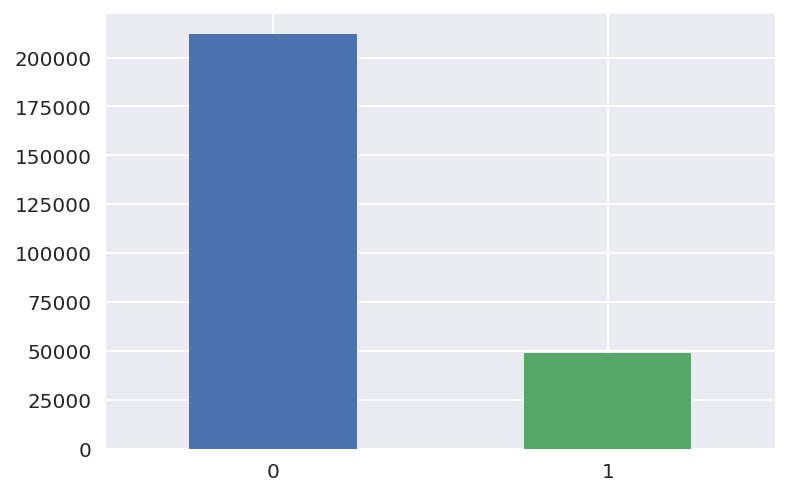

In [21]:
train[target_column].value_counts().plot.bar(rot=0)

## Inspect categorical columns

In [12]:
cat_columns = set(train.columns).difference(train._get_numeric_data().columns)

In [15]:
print(sorted(cat_columns))

['CoverageField8', 'CoverageField9', 'Field10', 'Field12', 'Field6', 'GeographicField63', 'GeographicField64', 'Original_Quote_Date', 'PersonalField16', 'PersonalField17', 'PersonalField18', 'PersonalField19', 'PersonalField7', 'PropertyField14', 'PropertyField28', 'PropertyField3', 'PropertyField30', 'PropertyField31', 'PropertyField32', 'PropertyField33', 'PropertyField34', 'PropertyField36', 'PropertyField37', 'PropertyField38', 'PropertyField4', 'PropertyField5', 'PropertyField7', 'SalesField7']


In [11]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260753 entries, 0 to 260752
Data columns (total 299 columns):
QuoteNumber             int64
Original_Quote_Date     object
QuoteConversion_Flag    int64
Field6                  object
Field7                  int64
Field8                  float64
Field9                  float64
Field10                 object
Field11                 float64
Field12                 object
CoverageField1A         int64
CoverageField1B         int64
CoverageField2A         int64
CoverageField2B         int64
CoverageField3A         int64
CoverageField3B         int64
CoverageField4A         int64
CoverageField4B         int64
CoverageField5A         int64
CoverageField5B         int64
CoverageField6A         int64
CoverageField6B         int64
CoverageField8          object
CoverageField9          object
CoverageField11A        int64
CoverageField11B        int64
SalesField1A            int64
SalesField1B            int64
SalesField2A            int64
SalesF

In [9]:
train._get_numeric_data().columns

Index(['QuoteNumber', 'QuoteConversion_Flag', 'Field7', 'Field8', 'Field9',
       'Field11', 'CoverageField1A', 'CoverageField1B', 'CoverageField2A',
       'CoverageField2B',
       ...
       'GeographicField58A', 'GeographicField58B', 'GeographicField59A',
       'GeographicField59B', 'GeographicField60A', 'GeographicField60B',
       'GeographicField61A', 'GeographicField61B', 'GeographicField62A',
       'GeographicField62B'],
      dtype='object', length=271)

In [17]:
for col in cat_columns:
    print(train[col].nunique(), '\t', col)

4 	 PropertyField33
19 	 PropertyField7
2 	 PropertyField36
868 	 Original_Quote_Date
2 	 PersonalField7
8 	 Field6
2 	 PropertyField32
57 	 PersonalField19
12 	 CoverageField9
7 	 CoverageField8
7 	 SalesField7
4 	 PropertyField31
2 	 PropertyField4
4 	 PropertyField28
2 	 PropertyField5
2 	 Field12
61 	 PersonalField18
4 	 GeographicField64
2 	 PropertyField37
2 	 PropertyField34
8 	 Field10
2 	 PropertyField38
4 	 PropertyField14
2 	 PropertyField3
2 	 PropertyField30
50 	 PersonalField16
66 	 PersonalField17
3 	 GeographicField63


## Date feature engineering

In [5]:
import re
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [19]:
train.head()

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField10A,PersonalField10B,PersonalField11,PersonalField12,PersonalField13,PersonalField14,PersonalField15,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PersonalField84,PropertyField1A,PropertyField1B,PropertyField2A,PropertyField2B,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField16A,PropertyField16B,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField21A,PropertyField21B,PropertyField22,PropertyField23,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField27,PropertyField28,PropertyField29,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField35,PropertyField36,PropertyField37,PropertyField38,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField5A,GeographicField5B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField10A,GeographicField10B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField14A,GeographicField14B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18A,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21A,GeographicField21B,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,GeographicField32A,GeographicField32B,GeographicField33A,GeographicField33B,GeographicField34A,GeographicField34B,GeographicField35A,GeographicField35B,GeographicField36A,GeographicFie

In [8]:
train.shape

(260753, 299)

In [6]:
add_datepart(train, 'Original_Quote_Date')

In [10]:
train.shape

(260753, 311)

In [11]:
train.head()

,QuoteNumber,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField10A,PersonalField10B,PersonalField11,PersonalField12,PersonalField13,PersonalField14,PersonalField15,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PersonalField84,PropertyField1A,PropertyField1B,PropertyField2A,PropertyField2B,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField16A,PropertyField16B,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField21A,PropertyField21B,PropertyField22,PropertyField23,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField27,PropertyField28,PropertyField29,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField35,PropertyField36,PropertyField37,PropertyField38,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField5A,GeographicField5B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField10A,GeographicField10B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField14A,GeographicField14B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18A,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21A,GeographicField21B,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,GeographicField32A,GeographicField32B,GeographicField33A,GeographicField33B,GeographicField34A,GeographicField34B,GeographicField35A,GeographicField35B,GeographicField36A,GeographicField36B,GeographicFiel

In [8]:
cat_columns = set(train.columns).difference(train._get_numeric_data().columns)

In [16]:
train.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
QuoteNumber,260753,NaN,NaN,NaN,217201,125479,1,108517,217012,325905,434588
QuoteConversion_Flag,260753,NaN,NaN,NaN,0.187511,0.390322,0,0,0,0,1
Field6,260753,8,B,94694,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Field7,260753,NaN,NaN,NaN,18.2933,7.3828,1,11,23,24,28
Field8,260753,NaN,NaN,NaN,0.938346,0.0370857,0.8746,0.9153,0.9403,0.9685,1.0101
Field9,260753,NaN,NaN,NaN,0.00145055,0.00148577,0.0004,0.0006,0.0006,0.0038,0.004
Field10,260753,8,935,52353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Field11,260753,NaN,NaN,NaN,1.16272,0.116833,1,1.02,1.1886,1.2665,1.3045
Field12,260753,2,N,241867,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CoverageField1A,260753,NaN,NaN,NaN,9.01253,5.57651,-1,5,8,12,25


In [13]:
for col in cat_columns:
    print(train[col].nunique(), '\t', col)

2 	 PersonalField7
4 	 GeographicField64
2 	 PropertyField4
2 	 PropertyField30
7 	 CoverageField8
7 	 SalesField7
50 	 PersonalField16
2 	 PropertyField36
19 	 PropertyField7
4 	 PropertyField14
12 	 CoverageField9
4 	 PropertyField31
2 	 PropertyField5
4 	 PropertyField28
2 	 PropertyField32
61 	 PersonalField18
57 	 PersonalField19
2 	 PropertyField34
8 	 Field6
2 	 PropertyField3
2 	 PropertyField38
2 	 Field12
2 	 PropertyField37
4 	 PropertyField33
8 	 Field10
3 	 GeographicField63
66 	 PersonalField17


## Label encode categorical columns (internally)

In [9]:
for col in cat_columns:
    train[col] = train[col].astype('category')

## Model

In [13]:
id_column = 'QuoteNumber'
target_column = 'QuoteConversion_Flag'

In [14]:
from lightgbm import LGBMClassifier

In [17]:
lgbm = LGBMClassifier()
lgbm.fit(train.drop([id_column, target_column], axis=1).iloc[:1000000], 
         train[target_column].iloc[:1000000])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

## Submission

In [22]:
test = pd.read_csv('../_data/test.csv', low_memory=False)

In [23]:
add_datepart(test, 'Original_Quote_Date')

In [24]:
for col in cat_columns:
    test[col] = test[col].astype('category')

In [26]:
submission = pd.DataFrame()
submission[id_column] = test[id_column]
submission[target_column] = lgbm.predict_proba(test.drop(id_column, axis=1))[:,1]
submission.to_csv('../_data/LGBM.csv', index=False)

In [27]:
submission.head()

,QuoteNumber,QuoteConversion_Flag
0,3,0.001182
1,5,0.050682
2,7,0.036623
3,9,0.012554
4,10,0.236708
